In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from numpy import savez_compressed, load
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU, Activation
from tensorflow.keras.layers import Dropout, Concatenate, BatchNormalization
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from skimage.metrics import structural_similarity as ssim



In [2]:
# ======================= 
# VGG FOR PERCEPTUAL LOSS
# =======================
def build_vgg():
    """Extract features from VGG19 for perceptual loss"""
    vgg = VGG19(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
    vgg.trainable = False
    model = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
    return model

def perceptual_loss(vgg_model):
    """Perceptual loss using VGG features"""
    def loss(y_true, y_pred):
        # Convert from [-1,1] to [0,255] for VGG
        y_true_scaled = (y_true + 1) * 127.5
        y_pred_scaled = (y_pred + 1) * 127.5
        
        # Preprocess for VGG
        from tensorflow.keras.applications.vgg19 import preprocess_input
        y_true_prep = preprocess_input(y_true_scaled)
        y_pred_prep = preprocess_input(y_pred_scaled)
        
        # Extract features
        true_features = vgg_model(y_true_prep)
        pred_features = vgg_model(y_pred_prep)
        
        # L1 loss on features
        return tf.reduce_mean(tf.abs(true_features - pred_features))
    return loss

# ======================= 
# PIX2PIX MODEL DEFINITIONS
# =======================

# --- Discriminator (PatchGAN) ---
def define_discriminator(image_shape_src, image_shape_tar):
    init = RandomNormal(stddev=0.02)
    in_src = Input(shape=image_shape_src)
    in_tar = Input(shape=image_shape_tar)
    merged = Concatenate()([in_src, in_tar])  # grayscale + RGB

    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Dropout(0.3)(d)
    patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)

    model = Model([in_src, in_tar], patch_out)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)

    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# --- Encoder Block ---
def encoder_block(layer_in, n_filters, batchnorm=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    if batchnorm:
        g = BatchNormalization()(g)
    g = LeakyReLU(alpha=0.2)(g)
    return g


# --- Decoder Block ---
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    init = RandomNormal(stddev=0.02)
    g = UpSampling2D(size=(2, 2))(layer_in)
    g = Conv2D(n_filters, (3, 3), padding='same', kernel_initializer=init)(g)
    g = BatchNormalization()(g)
    if dropout:
        g = Dropout(0.5)(g)
    g = Concatenate()([g, skip_in])
    g = Activation('relu')(g)
    return g

# --- Generator (U-Net) ---
def define_generator(image_shape=(256,256,1)):
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=image_shape)

    e1 = encoder_block(in_image, 64, batchnorm=False)
    e2 = encoder_block(e1, 128)
    e3 = encoder_block(e2, 256)
    e4 = encoder_block(e3, 512)
    e5 = encoder_block(e4, 512)
    e6 = encoder_block(e5, 512)
    e7 = encoder_block(e6, 512)
    
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = BatchNormalization()(b)
    b = Activation('relu')(b)

    d1 = decoder_block(b, e7, 512, dropout=True)
    d2 = decoder_block(d1, e6, 512, dropout=True)
    d3 = decoder_block(d2, e5, 512, dropout=True)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)

    g = UpSampling2D(size=(2, 2))(d7)
    out_image = Conv2D(3, (3, 3), padding='same', kernel_initializer=init, activation='tanh')(g)
    
    return Model(in_image, out_image)

# --- Combined Model (Generator + Discriminator) ---
def define_gan(g_model, d_model, image_shape_src):

    vgg = build_vgg()
    
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    
    in_src = Input(shape=image_shape_src)
    gen_out = g_model(in_src)
    dis_out = d_model([in_src, gen_out])
    
    model = Model(in_src, [dis_out, gen_out])
 
    opt = Adam(learning_rate=0.0002, beta_1=0.5, clipnorm=1.0)
    model.compile(
        loss=['binary_crossentropy', perceptual_loss(vgg)],
        loss_weights=[1, 100],
        optimizer=opt
    )
    return model


In [3]:

# ===========================
# Data Loading & Preprocessing
# ===========================
def load_images(path, size=(256,256)):
    """Loads paired A/B images from /A and /B subfolders."""
    src_list, tar_list = [], []
    pathA, pathB = os.path.join(path, 'A'), os.path.join(path, 'B')

    for fname in sorted(os.listdir(pathA)):
        if fname.startswith('.') or not fname.lower().endswith('.png'):
            continue
        imgA = load_img(os.path.join(pathA, fname), color_mode='grayscale', target_size=size)
        imgA = img_to_array(imgA)
        src_list.append(imgA)

    for fname in sorted(os.listdir(pathB)):
        if fname.startswith('.') or not fname.lower().endswith('.png'):
            continue
        imgB = load_img(os.path.join(pathB, fname), target_size=size)
        imgB = img_to_array(imgB)
        tar_list.append(imgB)

    return [np.asarray(src_list), np.asarray(tar_list)]

def prepare_data(dataset_path):
    """Loads images and saves them in a compressed .npz file."""
    [src, tar] = load_images(dataset_path)
    print(f'Loaded: source={src.shape}, target={tar.shape}')
    filename = os.path.join(dataset_path, 'dataset_256.npz')
    savez_compressed(filename, src, tar)
    print(f'Dataset saved: {filename}')
    return filename

# ===========================
# Dataset Loading Utility
# ===========================
def load_real_samples(filename):
    """Loads and scales dataset from [0,255] → [-1,1]."""
    data = load(filename)
    X1, X2 = data['arr_0'], data['arr_1']
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

# ===========================
# Data Augmentation
# ===========================
def augment_pair(imgA, imgB):
    """Apply same random augmentation to paired images"""
    # Random horizontal flip
    if np.random.random() > 0.5:
        imgA = np.fliplr(imgA)
        imgB = np.fliplr(imgB)
    
    # Random small rotation (-5 to 5 degrees)
    if np.random.random() > 0.5:
        from scipy.ndimage import rotate
        angle = np.random.uniform(-5, 5)
        imgA = rotate(imgA, angle, reshape=False, mode='nearest')
        imgB = rotate(imgB, angle, reshape=False, mode='nearest')
    
    return imgA, imgB

# ===========================
# Sampling Helpers
# ===========================
def generate_real_samples(dataset, n_samples, patch_shape, augment=True):
    trainA, trainB = dataset
    ix = np.random.randint(0, trainA.shape[0], n_samples)
    X1, X2 = trainA[ix].copy(), trainB[ix].copy()
    
    # IMPROVED: Apply augmentation
    if augment:
        for i in range(len(X1)):
            X1[i], X2[i] = augment_pair(X1[i], X2[i])
    
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

def generate_fake_samples(g_model, samples, patch_shape):
    X = g_model.predict(samples, verbose=0)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

def summarize_performance(step, g_model, dataset, n_samples=3, save_dir='Results'):
    """Plots example results and saves generator weights."""
    os.makedirs(save_dir, exist_ok=True)
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1, augment=False)
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)

    # scale back to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0

    plt.figure(figsize=(12, 12))

    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i].squeeze(), cmap='gray')

    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])

    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])

    filename1 = os.path.join(save_dir, f'plot_{step+1:06d}.png')
    plt.savefig(filename1, dpi=150, bbox_inches='tight')
    plt.close()

    filename2 = os.path.join(save_dir, f'model_{step+1:06d}.h5')
    g_model.save(filename2)
    print(f'> Saved {filename1} and {filename2}')

# ===========================
# Learning Rate Schedule
# ===========================
def lr_schedule(epoch, initial_lr=0.0002):
    """Decay learning rate after epoch 100"""
    if epoch < 100:
        return initial_lr
    else:
        return initial_lr * (0.99 ** (epoch - 100))


In [4]:
# ===========================
# VISUALIZATION
# ===========================
def plot_training_losses(df, save_dir='./Results'):
    """Create clean training loss plot"""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: Raw losses
    axes[0].plot(df['step'], df['d_loss_real'], alpha=0.4, linewidth=0.5, 
                color='blue', label='D Real')
    axes[0].plot(df['step'], df['d_loss_fake'], alpha=0.4, linewidth=0.5, 
                color='red', label='D Fake')
    axes[0].plot(df['step'], df['g_loss_total'], alpha=0.4, linewidth=0.5, 
                color='green', label='Generator')
    
    window = 100
    if len(df) > window:
        d_real_smooth = df['d_loss_real'].rolling(window=window, center=True).mean()
        d_fake_smooth = df['d_loss_fake'].rolling(window=window, center=True).mean()
        g_smooth = df['g_loss_total'].rolling(window=window, center=True).mean()
        
        axes[0].plot(df['step'], d_real_smooth, linewidth=2, color='blue')
        axes[0].plot(df['step'], d_fake_smooth, linewidth=2, color='red')
        axes[0].plot(df['step'], g_smooth, linewidth=2, color='green')
    
    axes[0].set_xlabel('Training Step', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training Losses', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    if len(df) > window:
        axes[1].plot(df['step'], d_real_smooth, linewidth=2.5, color='blue', label='Discriminator (Real)')
        axes[1].plot(df['step'], d_fake_smooth, linewidth=2.5, color='red', label='Discriminator (Fake)')
        axes[1].plot(df['step'], g_smooth, linewidth=2.5, color='green', label='Generator')
        
        axes[1].set_xlabel('Training Step', fontsize=12)
        axes[1].set_ylabel('Loss', fontsize=12)
        axes[1].set_title('Smoothed Training Losses (window=100)', fontsize=14, fontweight='bold')
        axes[1].legend(fontsize=10)
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    plot_path = os.path.join(save_dir, 'training_losses.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f'Saved training loss plot to {plot_path}')

In [5]:
# ===========================
# TRAINING WITH CSV LOGGING
# ===========================
def train_with_csv_logging(d_model, g_model, gan_model, dataset, n_epochs=200, n_batch=4, save_dir='./Results'):
    os.makedirs(save_dir, exist_ok=True)
    
    n_patch = d_model.output_shape[1]
    trainA, trainB = dataset
    bat_per_epo = int(len(trainA) / n_batch)
    n_steps = bat_per_epo * n_epochs
 
    training_log = []

    for i in range(n_steps):
        current_epoch = i // bat_per_epo
        
        # Update learning rate
        if i % bat_per_epo == 0:
            new_lr = lr_schedule(current_epoch)
            d_model.optimizer.learning_rate.assign(new_lr)
            gan_model.optimizer.learning_rate.assign(new_lr)
        
        # Training step
        [X_realA, X_realB], _ = generate_real_samples(dataset, n_batch, n_patch, augment=True)
        X_fakeB, _ = generate_fake_samples(g_model, X_realA, n_patch)

        y_real = np.ones((n_batch, n_patch, n_patch, 1)) * 0.9
        y_fake = np.zeros((n_batch, n_patch, n_patch, 1))

        d_loss_real = d_model.train_on_batch([X_realA, X_realB], y_real)
        d_loss_fake = d_model.train_on_batch([X_realA, X_fakeB], y_fake)

        y_gan = np.ones((n_batch, n_patch, n_patch, 1))
        g_loss_total, g_loss_adv, g_loss_l1 = gan_model.train_on_batch(X_realA, [y_gan, X_realB])
        
        # Get current learning rate
        current_lr = float(gan_model.optimizer.learning_rate.numpy())
        
        # Log to list
        training_log.append({
            'step': i + 1,
            'epoch': current_epoch,
            'd_loss_real': float(d_loss_real),
            'd_loss_fake': float(d_loss_fake),
            'd_loss_avg': float((d_loss_real + d_loss_fake) / 2),
            'g_loss_total': float(g_loss_total),
            'g_loss_adversarial': float(g_loss_adv),
            'g_loss_l1': float(g_loss_l1),
            'learning_rate': current_lr
        })
        
        
        # Save checkpoint
        if (i+1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model, dataset, save_dir=save_dir)
            
            # Save CSV at each checkpoint
            df = pd.DataFrame(training_log)
            csv_path = os.path.join(save_dir, 'training_losses.csv')
            df.to_csv(csv_path, index=False)
            print(f'  ✓ Saved training log to {csv_path}')
    
    # Final save
    df = pd.DataFrame(training_log)
    csv_path = os.path.join(save_dir, 'training_losses.csv')
    df.to_csv(csv_path, index=False)
    print(f'\n Final training log saved to {csv_path}')
    
    # Create visualization
    plot_training_losses(df, save_dir)
    
    return df


In [6]:
# ===========================
# SSIM VISUALIZATION
# ===========================
def plot_ssim_results(df, X_realA, X_realB, X_fakeB, save_dir='./Results'):
    """Create SSIM histogram and visual comparison"""
    
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
    
    # Top: SSIM histogram
    ax_hist = fig.add_subplot(gs[0, :])
    ax_hist.hist(df['ssim'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    ax_hist.axvline(df['ssim'].mean(), color='red', linestyle='--', linewidth=2.5, 
                   label=f'Mean SSIM = {df["ssim"].mean():.4f}')
    ax_hist.set_xlabel('SSIM Score', fontsize=12)
    ax_hist.set_ylabel('Frequency', fontsize=12)
    ax_hist.set_title('SSIM Distribution Across Test Set', fontsize=14, fontweight='bold')
    ax_hist.legend(fontsize=11)
    ax_hist.grid(True, alpha=0.3, axis='y')
    
    # Bottom: Visual examples (best, median, worst)
    ssim_scores = df['ssim'].values
    best_idx = np.argmax(ssim_scores)
    worst_idx = np.argmin(ssim_scores)
    median_idx = np.argsort(ssim_scores)[len(ssim_scores)//2]
    
    examples = [
        (best_idx, 'Best', ssim_scores[best_idx]),
        (median_idx, 'Median', ssim_scores[median_idx]),
        (worst_idx, 'Worst', ssim_scores[worst_idx])
    ]
    
    for col, (idx, label, score) in enumerate(examples):
        # Input
        ax1 = fig.add_subplot(gs[1, col])
        ax1.imshow(X_realA[idx].squeeze(), cmap='gray')
        ax1.axis('off')
        if col == 0:
            ax1.set_ylabel('Input', fontsize=12, fontweight='bold')
        ax1.set_title(f'{label} (SSIM={score:.4f})', fontsize=11, fontweight='bold')
        
        # Generated
        ax2 = fig.add_subplot(gs[2, col])
        ax2.imshow(X_fakeB[idx])
        ax2.axis('off')
        if col == 0:
            ax2.set_ylabel('Generated', fontsize=12, fontweight='bold')
        
        # Ground Truth
        ax3 = fig.add_subplot(gs[2, col+1] if col < 2 else gs[1, 3])
        if col < 2:
            ax3.imshow(X_realB[idx])
            ax3.axis('off')
            if col == 0:
                ax3.set_ylabel('Ground Truth', fontsize=12, fontweight='bold')
    
    plt.suptitle('SSIM Evaluation Results', fontsize=16, fontweight='bold')
    
    plot_path = os.path.join(save_dir, 'ssim_evaluation.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f'Saved SSIM visualization to {plot_path}')


In [7]:
# ===========================
# SSIM EVALUATION
# ===========================
def evaluate_ssim(g_model, dataset, save_dir='./Results', n_samples=100):
    """Evaluate SSIM on test samples and save to CSV"""
    
    os.makedirs(save_dir, exist_ok=True)
    
    print(f"Evaluating SSIM on {n_samples} samples...")
    
    # Generate predictions
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1, augment=False)
    X_fakeB = g_model.predict(X_realA, verbose=1)
    
    # Denormalize to [0, 1]
    X_realB_norm = (X_realB + 1) / 2.0
    X_fakeB_norm = (X_fakeB + 1) / 2.0
    
    # Calculate SSIM for each sample
    results = []
    for i in range(n_samples):
        ssim_val = ssim(X_realB_norm[i], X_fakeB_norm[i], 
                       multichannel=True, data_range=1.0, channel_axis=2)
        
        results.append({
            'sample_id': i,
            'ssim': float(ssim_val)
        })
    
    # Save to CSV
    df = pd.DataFrame(results)
    
    # Add summary statistics
    summary = pd.DataFrame([{
        'sample_id': 'MEAN',
        'ssim': df['ssim'].mean()
    }, {
        'sample_id': 'STD',
        'ssim': df['ssim'].std()
    }, {
        'sample_id': 'MIN',
        'ssim': df['ssim'].min()
    }, {
        'sample_id': 'MAX',
        'ssim': df['ssim'].max()
    }])
    
    df_full = pd.concat([df, summary], ignore_index=True)
    
    csv_path = os.path.join(save_dir, 'ssim_evaluation.csv')
    df_full.to_csv(csv_path, index=False)
    print(f'Saved SSIM results to {csv_path}')
    
    # Print summary
    print(f'\n SSIM Summary:')
    print(f'  Mean: {df["ssim"].mean():.4f}')
    print(f'  Std:  {df["ssim"].std():.4f}')
    print(f'  Min:  {df["ssim"].min():.4f}')
    print(f'  Max:  {df["ssim"].max():.4f}')
    
    # Create visualization
    plot_ssim_results(df, X_realA_norm, X_realB_norm, X_fakeB_norm, save_dir)
    
    return df


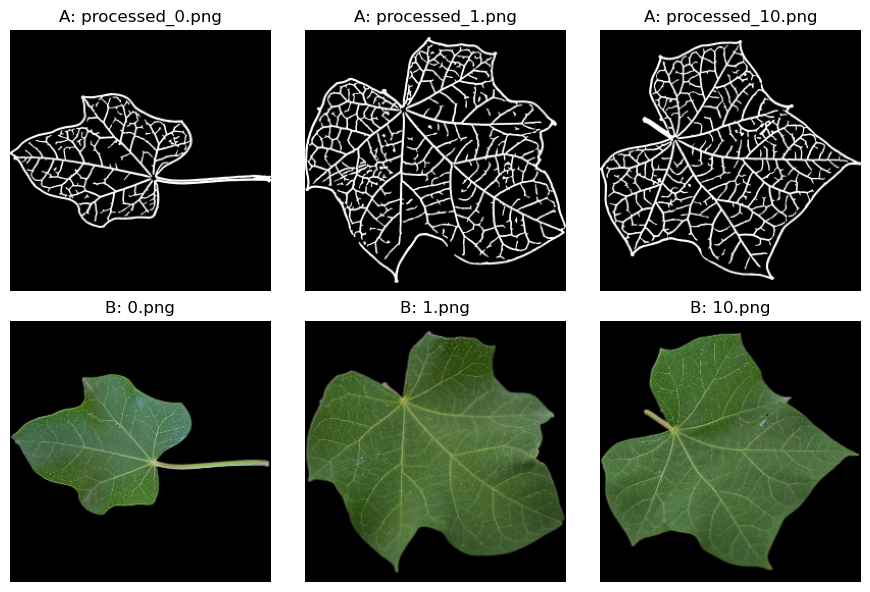

In [8]:
# ===========================
# Visualization Helper
# ===========================
pathA = './train/A'
pathB = './train/B'

if os.path.exists(pathA) and os.path.exists(pathB):
    filesA = sorted([f for f in os.listdir(pathA) if not f.startswith('.')])[:3]

    plt.figure(figsize=(9,6))
    for i, fA in enumerate(filesA):
        num = ''.join(filter(str.isdigit, fA))
        fB = f"{num}.png"

        if os.path.exists(os.path.join(pathB, fB)):
            imgA = img_to_array(load_img(os.path.join(pathA, fA), color_mode='grayscale')) / 255.0
            imgB = img_to_array(load_img(os.path.join(pathB, fB))) / 255.0

            plt.subplot(2,3,i+1); plt.imshow(imgA.squeeze(), cmap='gray'); plt.axis('off'); plt.title(f'A: {fA}')
            plt.subplot(2,3,i+4); plt.imshow(imgB); plt.axis('off'); plt.title(f'B: {fB}')

    plt.tight_layout()
    plt.show()


In [ ]:

# ===========================
# Run Training
# ===========================

# Create dataset if not already saved
dataset_path = './train/dataset_256.npz'
if not os.path.exists(dataset_path):
    dataset_path = prepare_data('./train')

# Load data
dataset = load_real_samples(dataset_path)
print('Loaded dataset:', dataset[0].shape, dataset[1].shape)

# Define input shapes
image_source_shape = dataset[0].shape[1:]
image_target_shape = dataset[1].shape[1:]

# Build models
d_model = define_discriminator(image_source_shape, image_target_shape)
g_model = define_generator(image_source_shape)
gan_model = define_gan(g_model, d_model, image_source_shape)

train_with_csv_logging(d_model, g_model, gan_model, dataset, n_epochs=300, n_batch=4, save_dir='./results_with_logs')

ssim_df = evaluate_ssim(g_model, dataset, save_dir='./results_with_logs', n_samples=100)

In [ ]:
def plot_ssim_analysis(csv_path='./Results/ssim_evaluation.csv', save_dir='./Results'):
    
    df = pd.read_csv(csv_path)
    
    df_data = df[pd.to_numeric(df['sample_id'], errors='coerce').notna()].copy()
    df_data['sample_id'] = df_data['sample_id'].astype(int)
    
    mean_ssim = df_data['ssim'].mean()
    std_ssim = df_data['ssim'].std()
    median_ssim = df_data['ssim'].median()
    min_ssim = df_data['ssim'].min()
    max_ssim = df_data['ssim'].max()
    
    # Create figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # ===========================
    # GRAPH 1: SSIM Distribution (Histogram)
    # ===========================
    ax1 = axes[0]
    
    n, bins, patches = ax1.hist(df_data['ssim'], bins=25, edgecolor='black', 
                                 alpha=0.8)
    
    for i, patch in enumerate(patches):
        if bins[i] < 0.7:
            patch.set_facecolor('#FF6B6B')  # Red - Poor
        elif bins[i] < 0.85:
            patch.set_facecolor('#FFD93D')  # Yellow - Medium
        else:
            patch.set_facecolor('#6BCB77')  # Green - Good
    
    ax1.axvline(mean_ssim, color='darkred', linestyle='--', linewidth=3, 
               label=f'Mean = {mean_ssim:.4f}')
    
    ax1.axvspan(mean_ssim - std_ssim, mean_ssim + std_ssim, 
               alpha=0.15, color='red', label=f'±1σ = {std_ssim:.4f}')
    
    ax1.set_xlabel('SSIM Score', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Number of Samples', fontsize=13, fontweight='bold')
    ax1.set_title('SSIM Distribution', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11, loc='upper left')
    ax1.grid(True, alpha=0.3, axis='y')
    
    stats_text = f'n = {len(df_data)}\n'
    stats_text += f'Mean = {mean_ssim:.4f}\n'
    stats_text += f'Median = {median_ssim:.4f}\n'
    stats_text += f'Std = {std_ssim:.4f}\n'
    stats_text += f'Range = [{min_ssim:.4f}, {max_ssim:.4f}]'
    
    ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, 
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # ===========================
    # GRAPH 2: SSIM Across Samples
    # ===========================
    ax2 = axes[1]
    
    # Scatter plot colored by SSIM value
    scatter = ax2.scatter(df_data['sample_id'], df_data['ssim'], 
                         c=df_data['ssim'], cmap='RdYlGn', 
                         s=60, alpha=0.7, edgecolors='black', linewidth=0.5,
                         vmin=0.5, vmax=1.0)

    ax2.axhline(mean_ssim, color='darkred', linestyle='--', linewidth=2.5, 
               label=f'Mean = {mean_ssim:.4f}')
    
    ax2.axhline(mean_ssim + std_ssim, color='red', linestyle=':', 
               linewidth=1.5, alpha=0.5, label='±1σ')
    ax2.axhline(mean_ssim - std_ssim, color='red', linestyle=':', 
               linewidth=1.5, alpha=0.5)
    
    ax2.axhspan(0.85, 1.0, alpha=0.1, color='green', label='Good (≥0.85)')
    ax2.axhspan(0.7, 0.85, alpha=0.1, color='yellow', label='Medium (0.7-0.85)')
    ax2.axhspan(0, 0.7, alpha=0.1, color='red', label='Poor (<0.7)')
    
    ax2.set_xlabel('Sample ID', fontsize=13, fontweight='bold')
    ax2.set_ylabel('SSIM Score', fontsize=13, fontweight='bold')
    ax2.set_title('SSIM Across Test Samples', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=9, loc='lower right')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0.5, 1.0])
    
    cbar = plt.colorbar(scatter, ax=ax2)
    cbar.set_label('SSIM Score', fontsize=11, fontweight='bold')
    
    plt.suptitle('SSIM Quality Analysis', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Save
    plot_path = os.path.join(save_dir, 'ssim_analysis.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    poor = (df_data['ssim'] < 0.7).sum()
    medium = ((df_data['ssim'] >= 0.7) & (df_data['ssim'] < 0.85)).sum()
    good = (df_data['ssim'] >= 0.85).sum()


In [ ]:
# -------------------------------------------------
# Load the trained generator model
# -------------------------------------------------
gen_path = './results_with_logs/model_009900.h5'
if os.path.exists(gen_path):
    generator = load_model(gen_path, compile=False)
    print(f'Loaded generator model: {gen_path}')

    # -------------------------------------------------
    # Utility: Load and preprocess a single image
    # -------------------------------------------------
    def load_single_image(filename, size=(256, 256)):
        """Load and normalize a grayscale input (vein/skeleton) image."""
        img = load_img(filename, color_mode='grayscale', target_size=size)
        img = img_to_array(img)
        img = (img - 127.5) / 127.5  # scale to [-1,1]
        img = np.expand_dims(img, axis=0)
        return img

    # -------------------------------------------------
    # Utility: Visualize triplet (input → generated → real)
    # -------------------------------------------------
    def plot_triplet(src_img, gen_img, tar_img=None, titles=['Input', 'Generated', 'Target']):
        """Display side-by-side comparison."""
        plt.figure(figsize=(12, 4))

        # Convert [-1,1] → [0,1]
        src_img = (src_img + 1) / 2.0
        gen_img = (gen_img + 1) / 2.0
        if tar_img is not None:
            tar_img = (tar_img + 1) / 2.0

        # Input
        plt.subplot(1, 3 if tar_img is not None else 2, 1)
        plt.imshow(src_img.squeeze(), cmap='gray')
        plt.title(titles[0])
        plt.axis('off')

        # Generated
        plt.subplot(1, 3 if tar_img is not None else 2, 2)
        plt.imshow(gen_img[0])
        plt.title(titles[1])
        plt.axis('off')

        # Target (optional)
        if tar_img is not None:
            plt.subplot(1, 3, 3)
            plt.imshow(tar_img.squeeze())
            plt.title(titles[2])
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    dataset_file = './train/dataset_256.npz'
    if os.path.exists(dataset_file):
        data = load(dataset_file)
        X1, X2 = data['arr_0'], data['arr_1']

        X1 = (X1 - 127.5) / 127.5
        X2 = (X2 - 127.5) / 127.5

        i = np.random.randint(0, X1.shape[0])
        src_sample, tar_sample = X1[i:i+1], X2[i:i+1]
        gen_sample = generator.predict(src_sample, verbose=0)

        plot_triplet(src_sample, gen_sample, tar_sample)

Loaded generator model: ./results_with_logs/model_009900.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


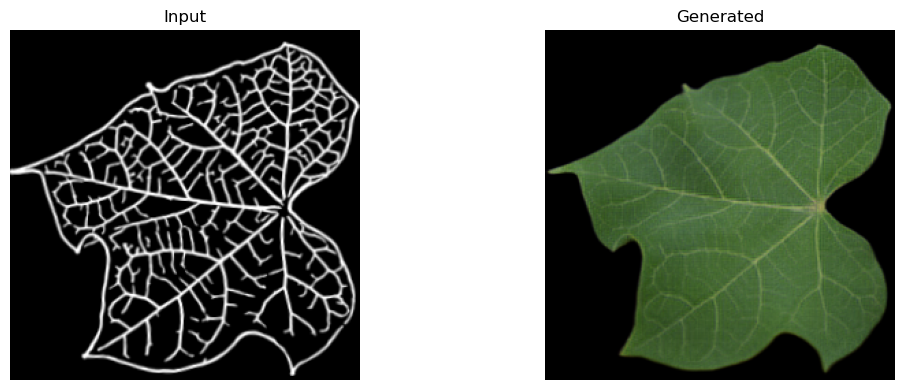

In [11]:

new_vein_path = './test.png'
src_sample = load_single_image(new_vein_path)

# No target image available for unseen vein
tar_sample = None

# Generate output
gen_sample = generator.predict(src_sample)

# Plot input vs generated
plot_triplet(src_sample, gen_sample, tar_sample)


In [ ]:
plot_ssim_analysis('./results_with_logs/ssim_evaluation.csv', save_dir='./results_with_logs')